# portfolio

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
from datetime import datetime
index = pd.Index([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
])
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}, index=index).astype(float)

print(ts)

              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0


In [4]:
big_ts = pd.DataFrame(np.random.uniform(size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
entries = pd.DataFrame.vbt.signals.generate_random(ts.shape, 2, min_space=1, seed=42, index=ts.index, columns=ts.columns)
big_entries = pd.DataFrame.vbt.signals.generate_random(big_ts.shape, 100, min_space=1, seed=42, index=big_ts.index)

print(entries)

                a      b      c      d
2020-01-01  False  False   True  False
2020-01-02  False  False  False  False
2020-01-03   True   True  False   True
2020-01-04  False  False  False  False
2020-01-05   True   True  False  False
2020-01-06  False  False  False  False
2020-01-07  False  False   True   True


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:152: NumbaWarning:

Cannot cache compiled function "generate_random_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



In [6]:
exits = entries.vbt.signals.generate_random_after(1, seed=42)
big_exits = big_entries.vbt.signals.generate_random_after(1, seed=42)

print(exits)

                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False   True  False
2020-01-03  False  False  False  False
2020-01-04   True   True  False  False
2020-01-05  False  False  False   True
2020-01-06  False   True  False  False
2020-01-07   True  False  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:163: NumbaWarning:

Cannot cache compiled function "generate_random_after_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



In [7]:
vbt.defaults.portfolio['init_capital'] = 100 # set init_capital in cash globally

## from_signals

In [8]:
portfolio = vbt.Portfolio.from_signals(ts['a'], entries['a'], exits['a'], volume=1)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0], volume=1)
print(vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0], volume=1).equity.shape)

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04   -1.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07   -1.0
Name: a, dtype: float64
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02    100.0
2020-01-03     97.0
2020-01-04    101.0
2020-01-05     96.0
2020-01-06     96.0
2020-01-07    103.0
Name: a, dtype: float64
7.9 ms ± 888 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [9]:
portfolio = vbt.Portfolio.from_signals(ts['a'], entries, exits, volume=1) # test broadcasting
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries, big_exits, volume=1)
print(vbt.Portfolio.from_signals(big_ts.iloc[:, 0], big_entries, big_exits, volume=1).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                a      b      c      d
2020-01-01  100.0  100.0   99.0  100.0
2020-01-02  100.0  100.0  101.0  100.0
2020-01-03   97.0   97.0  101.0   97.0
2020-01-04  101.0  101.0  101.0   97.0
2020-01-05   96.0   96.0  101.0  102.0
2020-01-06   96.0  102.0  101.0  102.0
2020-01-07  103.0  102.0   94.0   95.0
163 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [10]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=1)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                a      b      c      d
2020-01-01  100.0  100.0   99.0  100.0
2020-01-02  100.0  100.0  101.0  100.0
2020-01-03   97.0   93.0  101.0   98.0
2020-01-04  101.0   99.0  101.0   98.0
2020-01-05   96.0   94.0  101.0  100.0
2020-01-06   96.0   98.0  101.0  100.0
2020-01-07  103.0   98.0  100.0   96.0
151 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [11]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=np.inf) # all in/out
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=np.inf)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=np.inf).equity.shape)

                    a          b      c     d
2020-01-01   0.000000   0.000000  100.0   0.0
2020-01-02   0.000000   0.000000 -100.0   0.0
2020-01-03  33.333333  14.285714    0.0  50.0
2020-01-04 -33.333333 -14.285714    0.0   0.0
2020-01-05  26.666667  17.142857    0.0 -50.0
2020-01-06   0.000000 -17.142857    0.0   0.0
2020-01-07 -26.666667   0.000000  200.0  25.0
                    a          b      c     d
2020-01-01   0.000000   0.000000  100.0   0.0
2020-01-02   0.000000   0.000000    0.0   0.0
2020-01-03  33.333333  14.285714    0.0  50.0
2020-01-04   0.000000   0.000000    0.0  50.0
2020-01-05  26.666667  17.142857    0.0   0.0
2020-01-06  26.666667   0.000000    0.0   0.0
2020-01-07   0.000000   0.000000  200.0  25.0
                     a           b      c      d
2020-01-01  100.000000  100.000000    0.0  100.0
2020-01-02  100.000000  100.000000  200.0  100.0
2020-01-03    0.000000    0.000000  200.0    0.0
2020-01-04  133.333333   85.714286  200.0    0.0
2020-01-05    0.000

In [12]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=1, fees=0.01) # w/ fees
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)
print(portfolio.paid_fees)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, fees=0.01)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, fees=0.01).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                 a       b       c       d
2020-01-01  100.00  100.00   98.99  100.00
2020-01-02  100.00  100.00  100.97  100.00
2020-01-03   96.97   92.93  100.97   97.98
2020-01-04  100.93   98.87  100.97   97.98
2020-01-05   95.88   93.82  100.97   99.96
2020-01-06   95.88   97.78  100.97   99.96
2020-01-07  102.81   97.78   99.96   95.92
               a     b     c     d
2020-01-01  0.00  0.00  0.01  0.00
2020-01-02  0.00  0.00  0.02  0.00
2020-01-03  0.03  0.07  0.00  0.02
2020-01-04  0.04  0.

In [13]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, volume=1, slippage=0.01) # w/ slippage
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)
print(portfolio.paid_slippage)

%timeit vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, slippage=0.01)
print(vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, volume=1, slippage=0.01).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                 a       b       c       d
2020-01-01  100.00  100.00   98.99  100.00
2020-01-02  100.00  100.00  100.97  100.00
2020-01-03   96.97   92.93  100.97   97.98
2020-01-04  100.93   98.87  100.97   97.98
2020-01-05   95.88   93.82  100.97   99.96
2020-01-06   95.88   97.78  100.97   99.96
2020-01-07  102.81   97.78   99.96   95.92
               a     b     c     d
2020-01-01  0.00  0.00  0.01  0.00
2020-01-02  0.00  0.00  0.02  0.00
2020-01-03  0.03  0.07  0.00  0.02
2020-01-04  0.04  0.

## from_orders

In [14]:
volume = pd.DataFrame.vbt.timeseries.empty_like(ts, 1) # buy 1 share every day
big_volume = pd.DataFrame.vbt.timeseries.empty_like(big_ts, 1)

In [15]:
portfolio = vbt.Portfolio.from_volume(ts['a'], volume['a'])
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_volume(big_ts.iloc[:, 0], big_volume.iloc[:, 0])
print(vbt.Portfolio.from_volume(big_ts.iloc[:, 0], big_volume.iloc[:, 0]).equity.shape)

2020-01-01    1.0
2020-01-02    1.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    1.0
Name: a, dtype: float64
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
2020-01-06    6.0
2020-01-07    7.0
Name: a, dtype: float64
2020-01-01    99.0
2020-01-02    97.0
2020-01-03    94.0
2020-01-04    90.0
2020-01-05    85.0
2020-01-06    79.0
2020-01-07    72.0
Name: a, dtype: float64
5.38 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [16]:
portfolio = vbt.Portfolio.from_volume(ts['a'], volume)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_volume(big_ts.iloc[:, 0], big_volume)
print(vbt.Portfolio.from_volume(big_ts.iloc[:, 0], big_volume).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  99.0  99.0  99.0
2020-01-02  97.0  97.0  97.0  97.0
2020-01-03  94.0  94.0  94.0  94.0
2020-01-04  90.0  90.0  90.0  90.0
2020-01-05  85.0  85.0  85.0  85.0
2020-01-06  79.0  79.0  79.0  79.0
2020-01-07  72.0  72.0  72.0  72.0
65.5 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [17]:
portfolio = vbt.Portfolio.from_volume(ts, volume)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_volume(big_ts, big_volume)
print(vbt.Portfolio.from_volume(big_ts, big_volume).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  97.0  83.0  97.0  93.0
2020-01-03  94.0  76.0  94.0  91.0
2020-01-04  90.0  70.0  90.0  90.0
2020-01-05  85.0  65.0  87.0  88.0
2020-01-06  79.0  61.0  85.0  85.0
2020-01-07  72.0  58.0  84.0  81.0
61 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [18]:
portfolio = vbt.Portfolio.from_volume(ts, volume, is_target=True) # target amount of shares to hold
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_volume(big_ts, big_volume, is_target=True)
print(vbt.Portfolio.from_volume(big_ts, big_volume, is_target=True).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  0.0  0.0  0.0  0.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  0.0  0.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  0.0  0.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  99.0  91.0  99.0  96.0
2020-01-03  99.0  91.0  99.0  96.0
2020-01-04  99.0  91.0  99.0  96.0
2020-01-05  99.0  91.0  99.0  96.0
2020-01-06  99.0  91.0  99.0  96.0
2020-01-07  99.0  91.0  99.0  96.0
31 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


## from_order_func

In [19]:
@njit
def order_func_nb(col, i, run_cash, run_shares):
    return -i if i % 2 == 0 else i

portfolio = vbt.Portfolio.from_order_func(ts['a'], order_func_nb)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_ts.iloc[:, 0], order_func_nb)
print(vbt.Portfolio.from_order_func(big_ts.iloc[:, 0], order_func_nb).equity.shape)

2020-01-01    0.0
2020-01-02    1.0
2020-01-03   -1.0
2020-01-04    3.0
2020-01-05   -3.0
2020-01-06    5.0
2020-01-07   -5.0
Name: a, dtype: float64
2020-01-01    0.0
2020-01-02    1.0
2020-01-03    0.0
2020-01-04    3.0
2020-01-05    0.0
2020-01-06    5.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02     98.0
2020-01-03    101.0
2020-01-04     89.0
2020-01-05    104.0
2020-01-06     74.0
2020-01-07    109.0
Name: a, dtype: float64
3.47 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [20]:
portfolio = vbt.Portfolio.from_order_func(ts, order_func_nb)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_ts, order_func_nb)
print(vbt.Portfolio.from_order_func(big_ts, order_func_nb).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  0.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03 -1.0 -1.0 -1.0 -1.0
2020-01-04  3.0  3.0  3.0  3.0
2020-01-05 -3.0 -3.0 -3.0 -3.0
2020-01-06  5.0  5.0  5.0  5.0
2020-01-07 -5.0 -5.0 -5.0 -5.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  0.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  0.0  0.0  0.0  0.0
2020-01-04  3.0  3.0  3.0  3.0
2020-01-05  0.0  0.0  0.0  0.0
2020-01-06  5.0  5.0  5.0  5.0
2020-01-07  0.0  0.0  0.0  0.0
                a      b      c      d
2020-01-01  100.0  100.0  100.0  100.0
2020-01-02   98.0   92.0   98.0   97.0
2020-01-03  101.0   99.0  101.0   99.0
2020-01-04   89.0   81.0   89.0   96.0
2020-01-05  104.0   96.0   98.0  102.0
2020-01-06   74.0   76.0   88.0   87.0
2020-01-07  109.0   91.0   93.0  107.0
56 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


## Indexing and magic methods

In [8]:
portfolio = vbt.Portfolio.from_signals(ts, entries, exits, fees=0.01)
big_portfolio = vbt.Portfolio.from_signals(big_ts, big_entries, big_exits, fees=0.01)

In [22]:
print(portfolio.iloc[:, 0].equity)

%timeit big_portfolio.ts.iloc[:, 0]
%timeit big_portfolio.iloc[:, 0].ts

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03     99.009901
2020-01-04    130.693069
2020-01-05    129.399079
2020-01-06    155.278894
2020-01-07    179.347123
Name: a, dtype: float64
52.7 µs ± 724 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.75 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
portfolio_a = vbt.Portfolio.from_signals(ts, entries, exits, init_capital=100, fees=0.01, slippage=0.01)
portfolio_b = vbt.Portfolio.from_signals(ts, exits, entries, init_capital=200, fees=0.02, slippage=0.02)

portfolio_ab = portfolio_a + portfolio_b

print(portfolio_ab.init_capital)
print(portfolio_ab.ts)
print(portfolio_ab.cash)
print(portfolio_ab.shares)
print(portfolio_ab.paid_fees)
print(portfolio_ab.paid_slippage)

300.0
              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0
                     a           b           c           d
2020-01-01  300.000000  300.000000  200.000000  300.000000
2020-01-02  300.000000  300.000000  192.157632  300.000000
2020-01-03  200.000000  200.000000  192.157632  200.000000
2020-01-04  128.105088   82.353271  192.157632  200.000000
2020-01-05  230.776624  153.851083  192.157632   96.078816
2020-01-06  230.776624   63.299238  192.157632   96.078816
2020-01-07  172.314592   63.299238   92.310650  369.242599
                    a          b           c          d
2020-01-01   0.000000   0.000000   98.029605   0.000000
2020-01-02   0.000000   0.000000   96.116878   0.000000
2020-01-03  32.676535  14.004229   96.116878  49.014802
2020-01-04  48.058439  32.038959   96.116878  49.0

## Performance

In [9]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.cached_property = False

### Time series

In [10]:
print(portfolio['a'].cash)
print(portfolio.cash)

%timeit big_portfolio.cash

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03      0.000000
2020-01-04    130.693069
2020-01-05      0.000000
2020-01-06      0.000000
2020-01-07    179.347123
Name: a, dtype: float64
                     a           b           c           d
2020-01-01  100.000000  100.000000    0.000000  100.000000
2020-01-02  100.000000  100.000000  196.039604  100.000000
2020-01-03    0.000000    0.000000  196.039604    0.000000
2020-01-04  130.693069   84.016973  196.039604    0.000000
2020-01-05    0.000000    0.000000  196.039604   98.019802
2020-01-06    0.000000   65.882617  196.039604   98.019802
2020-01-07  179.347123   65.882617    0.000000    0.000000
55.9 ns ± 6.23 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [11]:
print(portfolio['a'].shares)
print(portfolio.shares)

%timeit big_portfolio.shares

2020-01-01     0.000000
2020-01-02     0.000000
2020-01-03    33.003300
2020-01-04     0.000000
2020-01-05    25.879816
2020-01-06    25.879816
2020-01-07     0.000000
Name: a, dtype: float64
                    a          b           c          d
2020-01-01   0.000000   0.000000   99.009901   0.000000
2020-01-02   0.000000   0.000000    0.000000   0.000000
2020-01-03  33.003300  14.144272    0.000000  49.504950
2020-01-04   0.000000   0.000000    0.000000  49.504950
2020-01-05  25.879816  16.637024    0.000000   0.000000
2020-01-06  25.879816   0.000000    0.000000   0.000000
2020-01-07   0.000000   0.000000  194.098618  24.262327
58.2 ns ± 5.91 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [12]:
print(portfolio['a'].paid_fees)
print(portfolio.paid_fees)

%timeit big_portfolio.paid_fees

2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.990099
2020-01-04    1.320132
2020-01-05    1.293991
2020-01-06    0.000000
2020-01-07    1.811587
Name: a, dtype: float64
                   a         b         c         d
2020-01-01  0.000000  0.000000  0.990099  0.000000
2020-01-02  0.000000  0.000000  1.980198  0.000000
2020-01-03  0.990099  0.990099  0.000000  0.990099
2020-01-04  1.320132  0.848656  0.000000  0.000000
2020-01-05  1.293991  0.831851  0.000000  0.990099
2020-01-06  0.000000  0.665481  0.000000  0.000000
2020-01-07  1.811587  0.000000  1.940986  0.970493
55.5 ns ± 3.8 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [13]:
print(portfolio['a'].paid_slippage)
print(portfolio.paid_slippage)

%timeit big_portfolio.paid_slippage

2020-01-01    0.000000e+00
2020-01-02    0.000000e+00
2020-01-03   -1.421085e-14
2020-01-04    0.000000e+00
2020-01-05    0.000000e+00
2020-01-06    0.000000e+00
2020-01-07    0.000000e+00
Name: a, dtype: float64
                       a    b    c    d
2020-01-01  0.000000e+00  0.0  0.0  0.0
2020-01-02  0.000000e+00  0.0  0.0  0.0
2020-01-03 -1.421085e-14  0.0  0.0  0.0
2020-01-04  0.000000e+00  0.0  0.0  0.0
2020-01-05  0.000000e+00  0.0  0.0  0.0
2020-01-06  0.000000e+00  0.0  0.0  0.0
2020-01-07  0.000000e+00  0.0  0.0  0.0
54.2 ns ± 3.93 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [14]:
print(portfolio['a'].equity)
print(portfolio.equity)

%timeit big_portfolio.equity

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03     99.009901
2020-01-04    130.693069
2020-01-05    129.399079
2020-01-06    155.278894
2020-01-07    179.347123
Name: a, dtype: float64
                     a           b           c           d
2020-01-01  100.000000  100.000000   99.009901  100.000000
2020-01-02  100.000000  100.000000  196.039604  100.000000
2020-01-03   99.009901   99.009901  196.039604   99.009901
2020-01-04  130.693069   84.016973  196.039604   49.504950
2020-01-05  129.399079   83.185122  196.039604   98.019802
2020-01-06  155.278894   65.882617  196.039604   98.019802
2020-01-07  179.347123   65.882617  194.098618   97.049309
5.37 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(portfolio['a'].equity_in_shares)
print(portfolio.equity_in_shares)

%timeit big_portfolio.equity_in_shares

2020-01-01    100.000000
2020-01-02     50.000000
2020-01-03     33.003300
2020-01-04     32.673267
2020-01-05     25.879816
2020-01-06     25.879816
2020-01-07     25.621018
Name: a, dtype: float64
                     a          b           c          d
2020-01-01  100.000000  11.111111   99.009901  25.000000
2020-01-02   50.000000  12.500000   98.019802  33.333333
2020-01-03   33.003300  14.144272   65.346535  49.504950
2020-01-04   32.673267  14.002829   49.009901  49.504950
2020-01-05   25.879816  16.637024   65.346535  49.009901
2020-01-06   25.879816  16.470654   98.019802  32.673267
2020-01-07   25.621018  21.960872  194.098618  24.262327
8.91 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(portfolio['a'].returns)
print(portfolio.returns)

%timeit big_portfolio.equity.pct_change()
%timeit big_portfolio.returns # numba helps a lot

2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.320000
2020-01-05   -0.009901
2020-01-06    0.200000
2020-01-07    0.155000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.000000 -0.009901
2020-01-04  0.320000 -0.151429  0.000000 -0.500000
2020-01-05 -0.009901 -0.009901  0.000000  0.980000
2020-01-06  0.200000 -0.208000  0.000000  0.000000
2020-01-07  0.155000  0.000000 -0.009901 -0.009901
281 ms ± 5.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.8 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(portfolio['a'].trades)
print(portfolio.trades)

%timeit big_portfolio.trades

2020-01-01     0.000000
2020-01-02     0.000000
2020-01-03    33.003300
2020-01-04   -33.003300
2020-01-05    25.879816
2020-01-06     0.000000
2020-01-07   -25.879816
Name: a, dtype: float64
                    a          b           c          d
2020-01-01   0.000000   0.000000   99.009901   0.000000
2020-01-02   0.000000   0.000000  -99.009901   0.000000
2020-01-03  33.003300  14.144272    0.000000  49.504950
2020-01-04 -33.003300 -14.144272    0.000000   0.000000
2020-01-05  25.879816  16.637024    0.000000 -49.504950
2020-01-06   0.000000 -16.637024    0.000000   0.000000
2020-01-07 -25.879816   0.000000  194.098618  24.262327
9.2 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


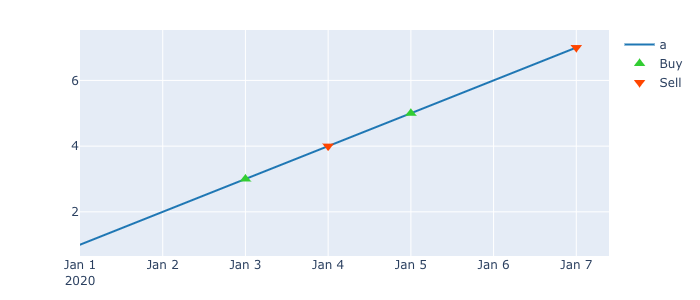

In [18]:
portfolio['a'].plot_trades().show_png()

In [19]:
print(portfolio['a'].drawdown)
print(portfolio.drawdown)

%timeit big_portfolio.drawdown

2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.009901
2020-01-04    0.000000
2020-01-05    0.009901
2020-01-06    0.000000
2020-01-07    0.000000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01  0.000000  0.000000  0.000000  0.000000
2020-01-02  0.000000  0.000000  0.000000  0.000000
2020-01-03  0.009901  0.009901  0.000000  0.009901
2020-01-04  0.000000  0.159830  0.000000  0.504950
2020-01-05  0.009901  0.168149  0.000000  0.019802
2020-01-06  0.000000  0.341174  0.000000  0.019802
2020-01-07  0.000000  0.341174  0.009901  0.029507
25.6 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Positions

In [20]:
print(portfolio['a'].open_positions)
print(portfolio['a'].closed_positions)
print(portfolio['a'].positions)

In [21]:
print(portfolio['a'].positions.status)
print(portfolio.positions.status)

%timeit big_portfolio.positions.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    1.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  1.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  1.0  NaN  0.0  0.0
8.6 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
print(portfolio['a'].positions.winning.status)
print(portfolio.positions.winning.status)

%timeit big_portfolio.positions.winning.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    1.0
Name: a, dtype: float64
              a   b    c   d
2020-01-01  NaN NaN  NaN NaN
2020-01-02  NaN NaN  1.0 NaN
2020-01-03  NaN NaN  NaN NaN
2020-01-04  1.0 NaN  NaN NaN
2020-01-05  NaN NaN  NaN NaN
2020-01-06  NaN NaN  NaN NaN
2020-01-07  1.0 NaN  NaN NaN
19 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
print(portfolio['a'].positions.losing.status)
print(portfolio.positions.losing.status)

%timeit big_portfolio.positions.losing.status

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
2020-01-06   NaN
2020-01-07   NaN
Name: a, dtype: float64
             a    b    c    d
2020-01-01 NaN  NaN  NaN  NaN
2020-01-02 NaN  NaN  NaN  NaN
2020-01-03 NaN  NaN  NaN  NaN
2020-01-04 NaN  1.0  NaN  NaN
2020-01-05 NaN  NaN  NaN  1.0
2020-01-06 NaN  1.0  NaN  NaN
2020-01-07 NaN  NaN  0.0  0.0
20.9 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
print(portfolio['a'].positions.count)
print(portfolio.positions.count)

%timeit big_portfolio.positions.count

2.0
a    2.0
b    2.0
c    2.0
d    2.0
dtype: float64
14 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print(portfolio['a'].positions.winning.count)
print(portfolio.positions.winning.count)

%timeit big_portfolio.positions.winning.count

2.0
a    2.0
b    NaN
c    1.0
d    NaN
dtype: float64
24.9 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
print(portfolio['a'].positions.losing.count)
print(portfolio.positions.losing.count)

%timeit big_portfolio.positions.losing.count

nan
a    NaN
b    2.0
c    1.0
d    2.0
dtype: float64
25 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
print(portfolio['a'].positions.duration)
print(portfolio.positions.duration)

%timeit big_portfolio.positions.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    2.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  2.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  2.0  NaN  1.0  1.0
6.09 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print(portfolio['a'].positions.winning.duration)
print(portfolio.positions.winning.duration)

%timeit big_portfolio.positions.winning.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    2.0
Name: a, dtype: float64
              a   b    c   d
2020-01-01  NaN NaN  NaN NaN
2020-01-02  NaN NaN  1.0 NaN
2020-01-03  NaN NaN  NaN NaN
2020-01-04  1.0 NaN  NaN NaN
2020-01-05  NaN NaN  NaN NaN
2020-01-06  NaN NaN  NaN NaN
2020-01-07  2.0 NaN  NaN NaN
17.6 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(portfolio['a'].positions.losing.duration)
print(portfolio.positions.losing.duration)

%timeit big_portfolio.positions.losing.duration

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
2020-01-06   NaN
2020-01-07   NaN
Name: a, dtype: float64
             a    b    c    d
2020-01-01 NaN  NaN  NaN  NaN
2020-01-02 NaN  NaN  NaN  NaN
2020-01-03 NaN  NaN  NaN  NaN
2020-01-04 NaN  1.0  NaN  NaN
2020-01-05 NaN  NaN  NaN  2.0
2020-01-06 NaN  1.0  NaN  NaN
2020-01-07 NaN  NaN  1.0  1.0
17.2 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
print(portfolio['a'].positions.avg_duration)
print(portfolio.positions.avg_duration)

%timeit big_portfolio.positions.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b   1 days 00:00:00
c   1 days 00:00:00
d   1 days 12:00:00
dtype: timedelta64[ns]
28 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
print(portfolio['a'].positions.winning.avg_duration)
print(portfolio.positions.winning.avg_duration)

%timeit big_portfolio.positions.winning.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b               NaT
c   1 days 00:00:00
d               NaT
dtype: timedelta64[ns]
37.6 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
print(portfolio['a'].positions.losing.avg_duration)
print(portfolio.positions.losing.avg_duration)

%timeit big_portfolio.positions.losing.avg_duration

nan
a               NaT
b   1 days 00:00:00
c   1 days 00:00:00
d   1 days 12:00:00
dtype: timedelta64[ns]
38.2 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
print(portfolio['a'].positions.pnl)
print(portfolio.positions.pnl)

%timeit big_portfolio.positions.pnl

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    30.693069
2020-01-05          NaN
2020-01-06          NaN
2020-01-07    48.654054
Name: a, dtype: float64
                    a          b          c         d
2020-01-01        NaN        NaN        NaN       NaN
2020-01-02        NaN        NaN  96.039604       NaN
2020-01-03        NaN        NaN        NaN       NaN
2020-01-04  30.693069 -15.983027        NaN       NaN
2020-01-05        NaN        NaN        NaN -1.980198
2020-01-06        NaN -18.134357        NaN       NaN
2020-01-07  48.654054        NaN  -1.940986 -0.970493
26.7 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


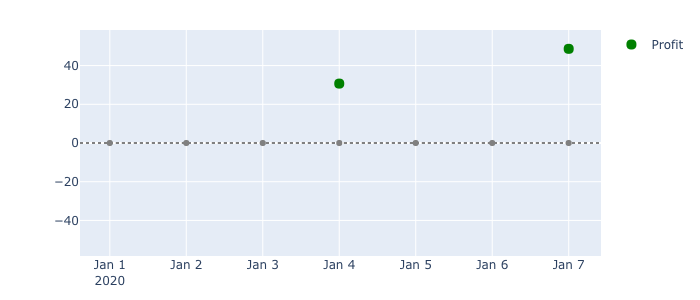

In [34]:
portfolio['a'].positions.plot_pnl().show_png()

In [35]:
print(portfolio['a'].positions.total_win)
print(portfolio.positions.total_win)

%timeit big_portfolio.positions.total_win

79.34712283109499
a    79.347123
b     0.000000
c    96.039604
d     0.000000
dtype: float64
34.4 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
print(portfolio['a'].positions.total_loss)
print(portfolio.positions.total_loss)

%timeit big_portfolio.positions.total_loss

0.0
a     0.000000
b    34.117383
c     1.940986
d     2.950691
dtype: float64
39.3 ms ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
print(portfolio['a'].positions.avg_win)
print(portfolio.positions.avg_win)

%timeit big_portfolio.positions.avg_win

39.673561415547496
a    39.673561
b     0.000000
c    96.039604
d     0.000000
dtype: float64
41.8 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
print(portfolio['a'].positions.avg_loss)
print(portfolio.positions.avg_loss)

%timeit big_portfolio.positions.avg_loss

0.0
a     0.000000
b    17.058692
c     1.940986
d     1.475346
dtype: float64
45.4 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
print(portfolio['a'].positions.win_rate)
print(portfolio.positions.win_rate)

%timeit big_portfolio.positions.win_rate

1.0
a    1.0
b    0.0
c    0.5
d    0.0
dtype: float64
33.9 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
print(portfolio['a'].positions.loss_rate)
print(portfolio.positions.loss_rate)

%timeit big_portfolio.positions.loss_rate

0.0
a    0.0
b    1.0
c    0.5
d    1.0
dtype: float64
33.3 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
print(portfolio['a'].positions.profit_factor)
print(portfolio.positions.profit_factor)

%timeit big_portfolio.positions.profit_factor

inf
a          inf
b     0.000000
c    49.479798
d     0.000000
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/portfolio.py:174: RuntimeWarning:

divide by zero encountered in true_divide



66.5 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
print(portfolio['a'].positions.expectancy)
print(portfolio.positions.expectancy)

%timeit big_portfolio.positions.expectancy

39.673561415547496
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
133 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
print(portfolio['a'].positions.returns)
print(portfolio.positions.returns)

%timeit big_portfolio.positions.returns

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    0.306931
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    0.372277
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02       NaN       NaN  0.960396       NaN
2020-01-03       NaN       NaN       NaN       NaN
2020-01-04  0.306931 -0.159830       NaN       NaN
2020-01-05       NaN       NaN       NaN -0.019802
2020-01-06       NaN -0.215842       NaN       NaN
2020-01-07  0.372277       NaN -0.009901 -0.009901
26.9 ms ± 882 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


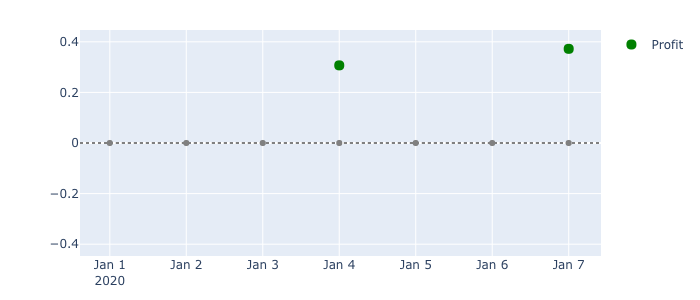

In [44]:
portfolio['a'].positions.plot_returns().show_png()

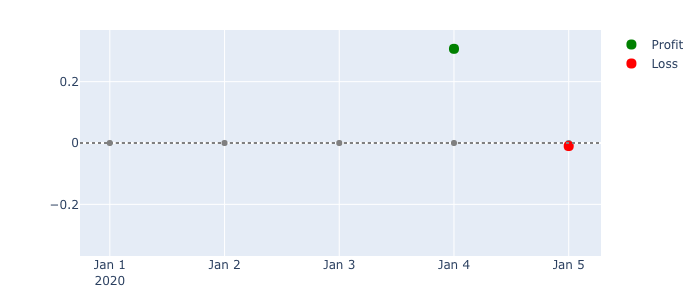

In [45]:
portfolio['a'].positions.iloc[:5].plot_returns().show_png()

### Costs

In [46]:
print(portfolio['a'].total_paid_fees)
print(portfolio.total_paid_fees)

%timeit big_portfolio.total_paid_fees

5.415808907623429
a    5.415809
b    3.336087
c    4.911283
d    2.950691
dtype: float64
857 µs ± 5.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
print(portfolio['a'].total_paid_slippage)
print(portfolio.total_paid_slippage)

%timeit big_portfolio.total_paid_slippage

-1.4210854715202004e-14
a   -1.421085e-14
b    0.000000e+00
c    0.000000e+00
d    0.000000e+00
dtype: float64
995 µs ± 137 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [48]:
print(portfolio['a'].total_costs)
print(portfolio.total_costs)

%timeit big_portfolio.total_costs

5.415808907623415
a    5.415809
b    3.336087
c    4.911283
d    2.950691
dtype: float64
2.44 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### General

In [49]:
print(portfolio['a'].total_profit)
print(portfolio.total_profit)

%timeit big_portfolio.total_profit

79.34712283109499
a    79.347123
b   -34.117383
c    94.098618
d    -2.950691
dtype: float64
6.99 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
print(portfolio['a'].total_return)
print(portfolio.total_return)

%timeit big_portfolio.total_return

0.79347122831095
a    0.793471
b   -0.341174
c    0.940986
d   -0.029507
dtype: float64
6.86 ms ± 860 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
print(portfolio['a'].annual_return)
print(portfolio.annual_return)

%timeit big_portfolio.annual_return

2020    0.793471
Name: a, dtype: float64
             a         b         c         d
2020  0.793471 -0.341174  0.960396 -0.029507
20.2 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
print(portfolio['a'].max_drawdown)
print(portfolio.max_drawdown)

%timeit big_portfolio.max_drawdown

0.00990099009901002
a    0.009901
b    0.341174
c    0.009901
d    0.504950
dtype: float64
33.7 ms ± 8.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [174]:
from numba import generated_jit

@njit
def map_axis0_nb(a, map_func_nb, *args):
    result = np.empty_like(a, dtype=f8)

    for col in range(result.shape[1]):
        result[:, col] = map_func_nb(col, a[:, col], *args)
    return result

In [177]:
a = np.asarray([1., 2.])
b = a.astype(float)
b[0] = 3
b
a

array([1., 2.])

In [175]:
auto_mult_reduce_nb(ts.values, describe_mult_reduce_func_nb, np.asarray([0.25, 0.5, 0.75]))

AttributeError: 'Array' object has no attribute 'shape'

In [170]:
pd.Series(np.asarray([np.nan, np.nan, np.nan])).describe(np.asarray([0.25, 0.5, 0.75]))

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [136]:
np.std(ts['a'], ddof=0) * np.sqrt(len(ts['a'])) / np.sqrt(len(ts['a'])-1)

2.160246899469287

In [130]:
np.sqrt(len(ts['a'])-1)

2.449489742783178

In [133]:
np.sqrt(np.var(ts['a']) / (len(ts['a'])-1))

0.816496580927726

In [123]:
np.std(ts['a'], ddof=1)

2.160246899469287

In [125]:
ts['a'].iloc[:1].describe()

count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: a, dtype: float64